In [905]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy import signal
from scipy.spatial import distance
import random

In [906]:
def plot(imgs, subplot_size=(1,1), figsz=(10,10), title=[None]):
    rows, columns = subplot_size #[0], img_array_size[1]
    plt.figure(figsize=figsz)
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(imgs[i])
        plt.title(title[i])
    plt.show()

In [907]:
MIN_MATCH_COUNT = 10

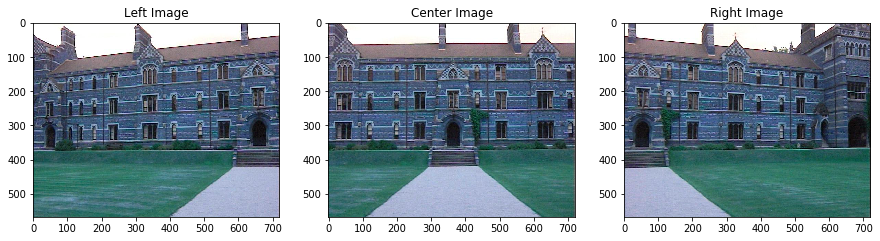

In [908]:
img_a = cv2.imread('./input_images/keble_a.jpg')
img_b = cv2.imread('./input_images/keble_b.jpg')
img_c = cv2.imread('./input_images/keble_c.jpg')

plot([img_a,img_b,img_c], (1,3), (15,15), ['Left Image','Center Image','Right Image'])

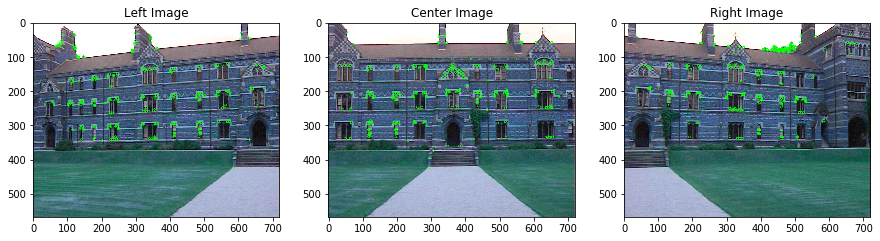

In [909]:
orb = cv2.ORB_create()

kp_a = orb.detect(img_a, None)
kp_a, des_a = orb.compute(img_a, kp_a)
imga_kp = cv2.drawKeypoints(img_a, kp_a, color=(0,255,0), outImage=None)

kp_b = orb.detect(img_b, None)
kp_b, des_b = orb.compute(img_b, kp_b)
imgb_kp = cv2.drawKeypoints(img_b, kp_b, color=(0,255,0), outImage=None)

kp_c = orb.detect(img_c, None)
kp_c, des_c = orb.compute(img_c, kp_c)
imgc_kp = cv2.drawKeypoints(img_c, kp_c, color=(0,255,0), outImage=None)

plot([imga_kp,imgb_kp,imgc_kp], (1,3), (15,15), ['Left Image','Center Image','Right Image'])

In [910]:
def computeH(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.array([corr[0], corr[1], 1])
        p2 = np.array([corr[2], corr[3], 1])
        a_y = [0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2],
               p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]]
        a_x = [-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0,
               p2[0] * p1[0], p2[0] * p1[1], p2[0] * p1[2]]
        aList.append(a_x)
        aList.append(a_y)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    #normalize and now we have h
    h = (1/h[2,2]) * h
    return h


In [911]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.array([correspondence[0], correspondence[1],1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2[0,2])*estimatep2

    p2 = np.transpose(np.array([correspondence[2], correspondence[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [912]:
def RANSAC(corr, thresh):
    maxInliers = []
    finalH = None
    print(corr.shape)
    for i in range(5000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))
        #print(randomFour)
        #call the homography function on those points
        h = computeH(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i,:], h)
            if d < 2:
                inliers.append(corr[i,:])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        #print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

def computeH(im1_pts, im2_pts):
    for i in range(im1_pts.shape[0]):
        

In [913]:
def findMatching(img1, img2, kp1, kp2, des1, des2):
    MIN_MATCH_COUNT = 10
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 6,#12,
                        key_size = 12,#20,
                        multi_probe_level = 1)#2)

    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    #matches = flann.knnMatch(des1.astype('float32'), des2.astype('float32'), k=2)
    matches = flann.knnMatch(des1, des2, k=2)
    #matches = flann.knnMatch(des2, des1, k=2)

    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ])#.reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ])#.reshape(-1,1,2)
        print('dst_points',dst_pts.shape)
        corr_pts = np.concatenate((src_pts,dst_pts), axis=1)
        corr_pts_r = np.concatenate((dst_pts,src_pts), axis=1)
        
        M, inliers = RANSAC(corr_pts, 0.6)
        _, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        #_, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
        matchesMask = mask.T.ravel().tolist()
        print(len(matchesMask))
        h,w = img2.shape[0:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        #img_a = cv2.polylines(img_a,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    ones_mask = np.ones((dst_pts.shape[0],1)).tolist()
    print(len(ones_mask))
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    #img_match = cv2.drawMatches(img2, kp2, img1, kp1, good, None, **draw_params)
    img_match = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

    plt.figure(figsize=(10,10))
    plt.imshow(img_match, 'gray'),plt.show()
    return M

dst_points (132, 2)
(132, 4)
132
132


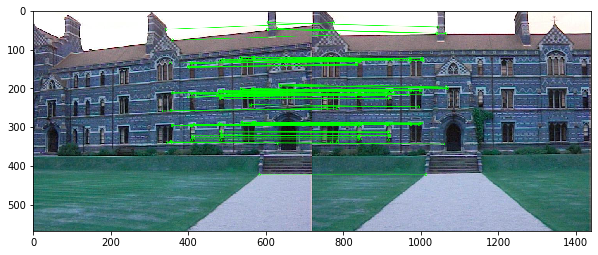

3 500


In [998]:
M = findMatching(img_a, img_b, kp_a, kp_b, des_a, des_b)
print(len(M), len(kp_a))
#M = findMatching(img_b,img_a,kp_b,kp_a,des_b,des_a)

dst_points (97, 2)
(97, 4)
97
97


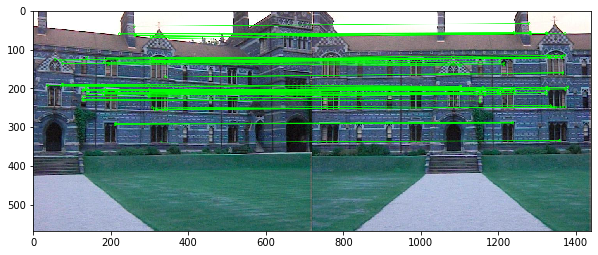

In [1000]:
M2 = findMatching(img_c, img_b, kp_c, kp_b, des_c, des_b)
#M2 = findMatching(img_b, img_c, kp_b, kp_c, des_b, des_c)

In [1001]:
print(M)
M1 = M
M1[0,2] = M1[0,2]+790
M1[1,2] = M1[1,2]
M2[0,2] = M1[0,2]-770
M2[1,2] = M2[1,2]

[[ 1.20727470e+00 -2.61572166e-02 -3.51514828e+02]
 [ 1.07542284e-01  1.14834468e+00 -5.26343345e+01]
 [ 2.83050288e-04  3.24174908e-05  1.00000000e+00]]


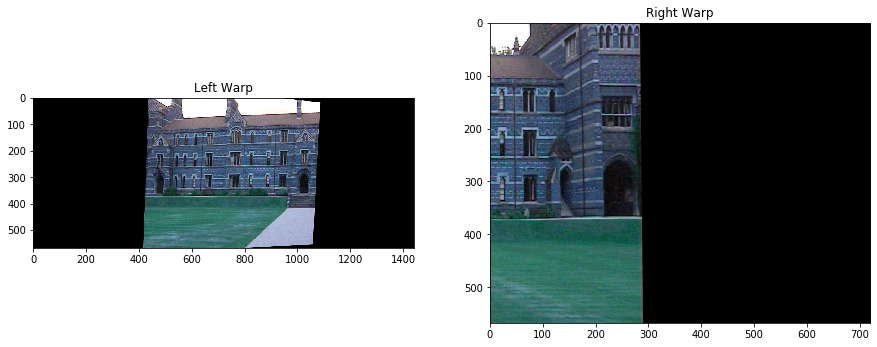

In [1002]:
#panorama = np.zeros((img_a.shape[0],img_a.shape[1]*3,3))
#panorama[:, img_a.shape[1]:] = cv2.warpPerspective(img_a, M1, (img_a.shape[1]+img_b.shape[1], img_a.shape[0]))
img_warp_l = cv2.warpPerspective(img_a, M1, (img_a.shape[1]+img_b.shape[1], img_a.shape[0]))
img_warp_r = cv2.warpPerspective(img_c, M2, (img_a.shape[1], img_a.shape[0]))
panorama = np.copy(img_warp_l)
plot([img_warp_l, img_warp_r], (1,2), (15,15), ['Left Warp','Right Warp'])

In [1003]:
panorama[0:img_b.shape[0], img_a.shape[1]:] = img_b
panorama = np.concatenate((panorama,np.zeros((panorama.shape[0],img_c.shape[1],3))),axis=1)
panorama[0:img_b.shape[0], img_a.shape[1]+img_b.shape[1]-1:-1] = img_warp_r
panorama_crop = panorama[:,img_a.shape[1]//2:-img_a.shape[1]//2]
#img_warp = np.zeros((img_warp_l.shape))
#img_warp[:img_a.shape[0], :img_a.shape[1]] = img_warp_l[:img_a.shape[0],:img_a.shape[1]]
#img_warp[:img_b.shape[0], img_a.shape[1]:img_a.shape[1]+img_b.shape[1]] = img_b
#img_warp[:img_c.shape[0], img_a.shape[1]+img_b.shape[1]:img_a.shape[1]+img_b.shape[1]+img_c.shape[1]] = img_warp_r[:img_a.shape[0],:img_a.shape[1]]

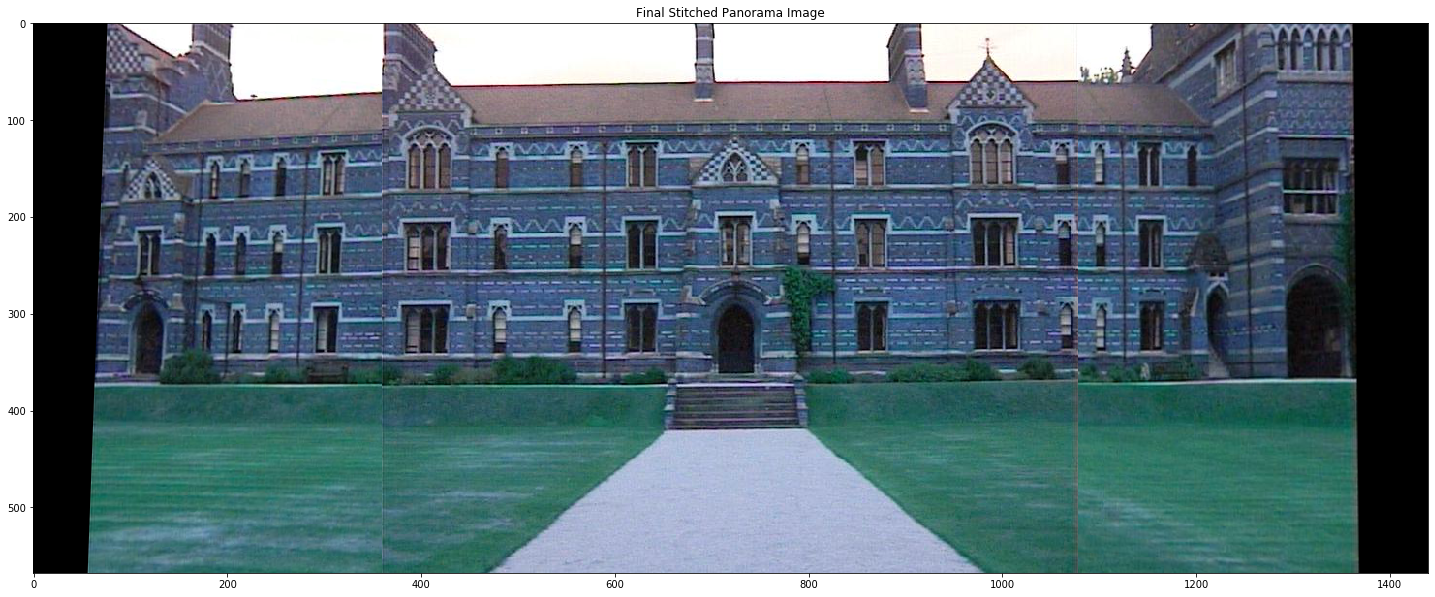

In [1004]:
plot([panorama_crop / 255], figsz = (25,25), title=['Final Stitched Panorama Image'])

In [ ]:
cv2.imwrite('./output_images/panorama.jpeg', panorama_crop)

True